In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Nov 18 14:40:49 2019

@author: L-F-S
@ University of Trento, Italy
"""

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

n='1'#str(input("Quale sample vuoi osservare? [0, 1, 2, 3, A]"))
is_deduped=True
if not is_deduped:
    dataname="/home/lorenzo/Cas_mining/mapping/vcf_pacbam_out/SS"+n+"_CJ_variant.sorted.pileup"
    samplename="S"+n
else:
    dataname="/home/lorenzo/Cas_mining/mapping/vcf_pacbam_out/deduped/SS"+n+"_CJ_variant.sorted.pileup"
    samplename="S"+n+"_dedup"
original_pileup=pd.read_csv(dataname, sep="\t", header=0)
print(original_pileup.columns) #chr, pos, ref , A, C , G , T, af , cov

Index(['chr', 'pos', 'ref', 'A', 'C', 'G', 'T', 'af', 'cov'], dtype='object')


In [2]:
#we are interested in values relative to coverage:
for letter in ["A", "T","C","G"]:
    original_pileup[letter]=round(original_pileup[letter]/original_pileup["cov"], 3)
print(original_pileup.tail())

          chr   pos ref      A      C      G      T        af   cov
3292  CJ_Cas9  3293   T  0.099  0.113  0.014  0.773  0.226572  2529
3293  CJ_Cas9  3294   A  0.702  0.048  0.074  0.176  0.298493  2057
3294  CJ_Cas9  3295   G  0.043  0.070  0.715  0.172  0.285479  1818
3295  CJ_Cas9  3296   A  0.480  0.070  0.042  0.409  0.520429  1493
3296  CJ_Cas9  3297   C  0.004  0.847  0.057  0.093  0.153257  1044


In [3]:
#index is the 1 based position (position 1 is missing for some reason, ma 
# fortunatamente non ci interessa)
pileup=original_pileup
#
CJ_start=151
CJ_end=3213
#add a label to the old data to indicate if this part belongs to CJ or not
pileup["is_protein"]= [ True if x>=CJ_start and x<= CJ_end else False for x in pileup["pos"] ]
pileup["pos"]=pileup["pos"]-CJ_start+1
#just slice out if needed:
#CJ_pileup=pileup[pileup["is_protein"]==True]

print(pileup.loc[149:153])
print(pileup.tail(2))

         chr  pos ref      A      C      G      T        af    cov  is_protein
149  CJ_Cas9    0   A  0.995  0.000  0.001  0.004  0.005464  38247       False
150  CJ_Cas9    1   A  0.999  0.000  0.000  0.001  0.001074  38175        True
151  CJ_Cas9    2   T  0.000  0.001  0.001  0.998  0.002277  37772        True
152  CJ_Cas9    3   G  0.001  0.000  0.998  0.001  0.002342  38850        True
153  CJ_Cas9    4   G  0.002  0.001  0.993  0.003  0.006754  38793        True
          chr   pos ref      A      C      G      T        af   cov  \
3295  CJ_Cas9  3146   A  0.480  0.070  0.042  0.409  0.520429  1493   
3296  CJ_Cas9  3147   C  0.004  0.847  0.057  0.093  0.153257  1044   

      is_protein  
3295       False  
3296       False  


In [4]:
print(pileup[pileup["pos"]==3063])


          chr   pos ref      A      C      G      T       af    cov  \
3212  CJ_Cas9  3063   A  0.993  0.001  0.002  0.003  0.00689  33092   

      is_protein  
3212        True  


In [39]:
#trucchetto per evidenziare il leibel:
def valore_ref(row): #1 aggiungi una colonna colla frazione della base reference
    letter=row["ref"]
    return row[letter]
def remove_ref(row):  #2 azzera la base reference
    letter=row["ref"]
    row[letter]=0.0
    return row

#CJ_pileup["ref_value"]=CJ_pileup.apply(valore_ref, axis=1)
#CJ_pileup=CJ_pileup.apply(remove_ref, axis=1)

pileup["ref_value"]=pileup.apply(valore_ref, axis=1)
pileup=pileup.apply(remove_ref, axis=1)

In [44]:
#plot senza distanze vere
cutoff=0.1 #allelic fraction cutoff over which to consider a mutation

CJ_sliced=pileup[pileup["af"]>=cutoff][pileup["is_protein"]==True] #bo nn se sa che ho fatto ma tanot nn fa piu il grafico qua

/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


TypeError: only size-1 arrays can be converted to Python scalars

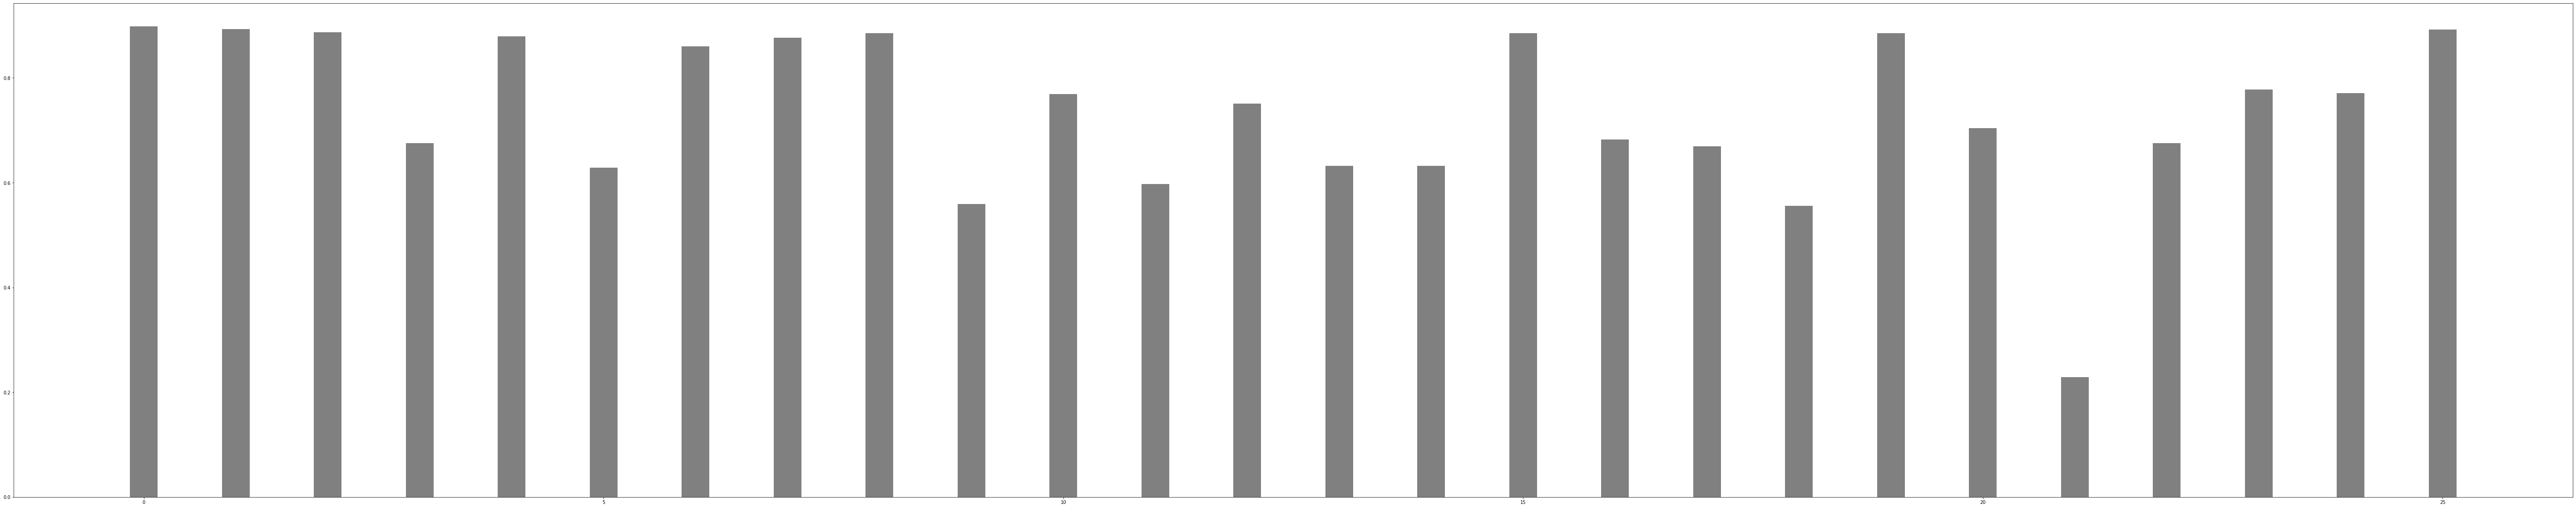

In [100]:
to_print=CJ_sliced.drop(['chr', "ref", "af", "cov"], axis=1)

color_of={"T":"#0066ff", "A":"#ffd11a","C":"red", "G":"#00e600", "ref_value":"grey"}

plot_of={}
plt.figure(figsize=(101,20))
width=0.3
#per farlo con distanze giuste lungo il coso, sostituisci 'np.arange(len(to_print["pos"]))' con to_print["pos"], e mettiwidth=10
plot_of["ref_value"]=plt.bar(np.arange(len(to_print["pos"])), to_print["ref_value"], width, color=color_of["ref_value"])
previous_letter=to_print["ref_value"]
for letter in ["A","T","C","G"]:
    plot_of[letter]=plt.bar(np.arange(len(to_print["pos"])), to_print[letter], width, bottom=previous_letter, color=color_of[letter])
    previous_letter+=to_print[letter]
plt.legend((plot_of["A"][0],plot_of["T"][0],plot_of["C"][0],plot_of["G"][0]),("A","T","C","G"), fontsize=50)
plt.yticks(size=50)

plt.xticks(np.arange(len(to_print["pos"])), [str(bu["pos"])+":"+str(bu["ref"]) for bo, bu in CJ_sliced.iterrows()], size=50)
plt.savefig("imgs/mutated_positions_"+samplename+".png") 

In [46]:
CJ_pileup=pileup[pileup["is_protein"]==True]

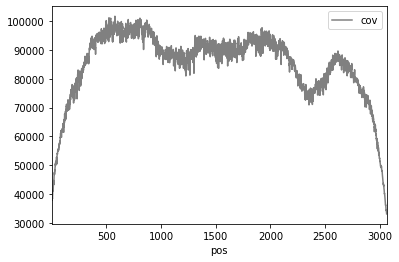

In [47]:
# plot coverage

CJ_pileup.plot(x='pos', y='cov',color='gray')
plt.savefig("imgs/"+samplename+"_coverage.png")

In [142]:
#there is a fall in coverage at pos 2200-2400 


In [139]:
print("median absolute deviation", CJ_pileup["af"].mad())

median absolute deviation 0.006554116963933705


count    3063.000000
mean        0.008546
std         0.027214
min         0.000905
25%         0.003328
50%         0.004959
75%         0.007353
max         0.752097
Name: af, dtype: float64
median	 0.004959000000000001


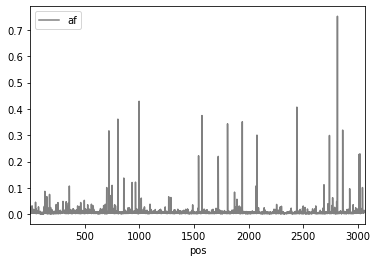

In [70]:
#plot allelic fraction
CJ_pileup.plot(x='pos', y='af',color='gray')
plt.savefig("S"+n+"_af.png")
print(CJ_pileup["af"].describe())
print("median\t", CJ_pileup["af"].median())
plt.savefig("imgs/"+samplename+"_af.png")

In [5]:
from plotnine import *

In [17]:
def mycolorpalette(color):
    if color:
        return "cyan"
    return "gray"

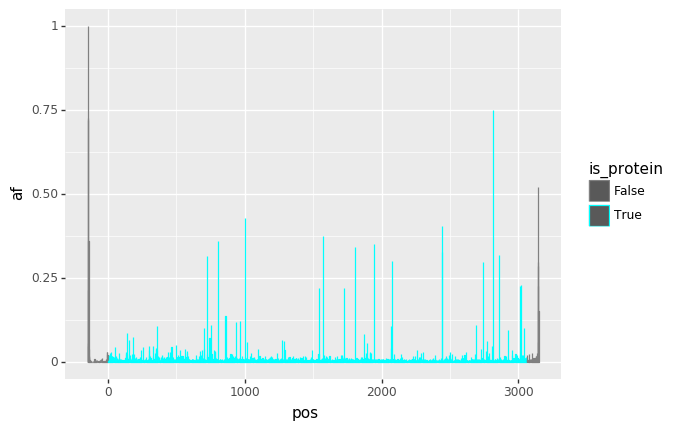

<ggplot: (8791097038789)>

In [6]:
(ggplot(pileup)         # defining what data to use
 + aes(x='pos', y='af', color="is_protein")      # defining what variable to use
 +geom_col()# defining the type of plot to use
 +scale_color_manual(values={False:"grey", True:"cyan"})
)

In [164]:
pileup.head()

,chr,pos,ref,A,C,G,T,af,cov,is_protein,ref_value
0,CJ_Cas9,-149,G,0.727,0.0,0.000,0.000,0.727273,55,False,0.273
1,CJ_Cas9,-148,C,0.017,0.0,0.729,0.254,1.000000,59,False,0.000
2,CJ_Cas9,-147,A,0.000,0.0,0.016,0.705,0.721311,61,False,0.279
3,CJ_Cas9,-146,T,0.024,0.0,0.024,0.000,0.047619,84,False,0.952
4,CJ_Cas9,-145,A,0.000,0.0,0.000,0.057,0.057471,87,False,0.943


In [7]:
# create a dataset with 4 more rows per column, and one more column called 'color_map' (which can be A,C,T,G,ref,plasmid), so every column tells
# what the value is, and the rows A,C,T,G,ref are just 1 row: value

def reshape_dataframe(pileup):
    reshaped_pileup=pd.DataFrame(columns=["pos","ref","value","color_map"])
#    reshaped_ind=0
    for ind, position in pileup.iterrows():
 #       is_protein=position["is_protein"]
        pos=position["pos"]
        ref=position["ref"]
        newrow={"pos":pos,"ref":ref}
   #     print("sono alla posizione: ", pos)
        for cosetta in ["A","T","G","C"]:
   #         print("lettera"+cosetta+"\n")
            temp_value=position[cosetta]
            newrow["value"]=temp_value
            newrow["color_map"]=cosetta
            reshaped_pileup=reshaped_pileup.append(newrow,ignore_index=True)
  #          if not is_protein:
   #             reshaped_pileup.loc[reshaped_ind]["color_map"]="plasmid"
 #           reshaped_ind+=1
  #  reshaped.dropna(how="all", inplace=True) #drop rows completely blank (che ho messo un index troppo lungo)
    reshaped_pileup.fillna(value=0, inplace=True)  #sostituisci nan con 0
    return reshaped_pileup



In [9]:
reshaped_pileup=reshape_dataframe(pileup)

In [12]:
reshaped_pileup.head()

,pos,ref,value,color_map
0,-149,G,0.727,A
1,-149,G,0.000,T
2,-149,G,0.273,G
3,-149,G,0.000,C
4,-148,C,0.017,A


In [17]:
reshaped_pileup_noref=reshaped_pileup[reshaped_pileup["color_map"]!=reshaped_pileup["ref"]]

In [18]:
reshaped_pileup_noref.head()

,pos,ref,value,color_map
0,-149,G,0.727,A
1,-149,G,0.000,T
3,-149,G,0.000,C
4,-148,C,0.017,A
5,-148,C,0.254,T


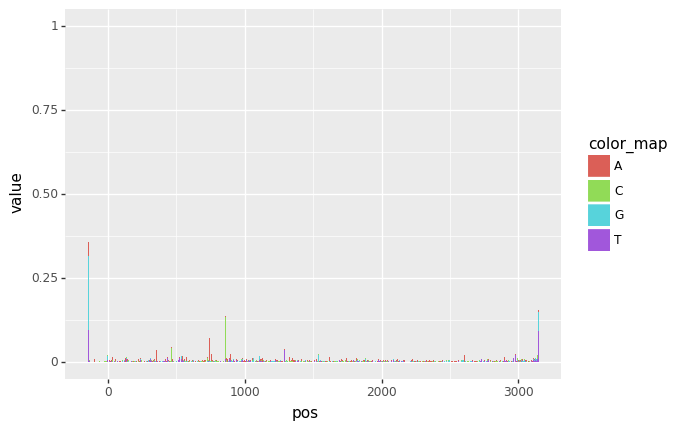

<ggplot: (-9223363245757916924)>

In [19]:
(ggplot(reshaped_pileup_noref)         
 + aes(x='pos', y='value', fill="color_map")      
 + geom_bar(position="stack", stat='identity')
)

In [8]:
def call_variant(position, median_af, mad_af):
    #takes as input a dataset with the af of each base, and the reference
    ref=position["ref"]
    k=1.4826
    af_of_variant={}
    for letter in ["A", "C","G","T"]:
        if letter != ref:
            temp_af=position[letter]
            if temp_af > median_af+mad_af*k:
                af_of_variant[letter]=temp_af  
    return af_of_variant

def call_variant_with_cutoff(position, cutoff):
    ref=position["ref"]
    k=1.4826
    af_of_variant={}
    for letter in ["A", "C","G","T"]:
        if letter != ref:
            temp_af=position["af"]
            if temp_af >= cutoff:
                af_of_variant[letter]=position[letter]  
    return af_of_variant

In [9]:
median_af=pileup["af"].median()
mad_af=pileup["af"].mad()
called_variants=pd.DataFrame()
for ind, position in pileup.iterrows():
    pos=int(position["pos"])
    ref=position["ref"]
    new_row={"pos":pos,"ref":ref}
    if position["is_protein"]:
        variants=call_variant(position,median_af,mad_af)
        new_row.update(variants)
        called_variants=called_variants.append(new_row, ignore_index=True)
called_variants.dropna(subset=["A","C","G","T"],how="all", inplace=True)
print(called_variants.head())

       pos ref      A      G   C   T
4      5.0   G  0.019    NaN NaN NaN
10    11.0   C  0.026    NaN NaN NaN
18    19.0   A    NaN  0.029 NaN NaN
50    51.0   G  0.041    NaN NaN NaN
129  130.0   T  0.022    NaN NaN NaN


In [59]:
called_variants.shape

(108, 6)

In [356]:
cutoff_called_variants=pd.DataFrame()
for ind, position in pileup.iterrows():
    pos=int(position["pos"])
    ref=position["ref"]
    new_row={"pos":pos,"ref":ref}
    if position["is_protein"]:
        variants=call_variant_with_cutoff(position,0.1)
        new_row.update(variants)
        cutoff_called_variants=cutoff_called_variants.append(new_row, ignore_index=True)
cutoff_called_variants.dropna(subset=["A","C","G","T"],how="all", inplace=True)
print(cutoff_called_variants.head())

       pos ref      C      G      T      A
359  360.0   A  0.002  0.001  0.104    NaN
701  702.0   G  0.001    NaN  0.099  0.002
721  722.0   T  0.315  0.001    NaN  0.001
750  751.0   G  0.001    NaN  0.003  0.106
803  804.0   T  0.002  0.001    NaN  0.358


In [359]:
print(cutoff_called_variants.shape)

(25, 6)


In [63]:
reshaped=reshape_dataframe(called_variants)
print(reshaped.shape)
print(reshaped.head())


(432, 4)
    pos ref  value color_map
0   5.0   G  0.019         A
1   5.0   G  0.000         T
2   5.0   G  0.000         G
3   5.0   G  0.000         C
4  11.0   C  0.026         A


plotting


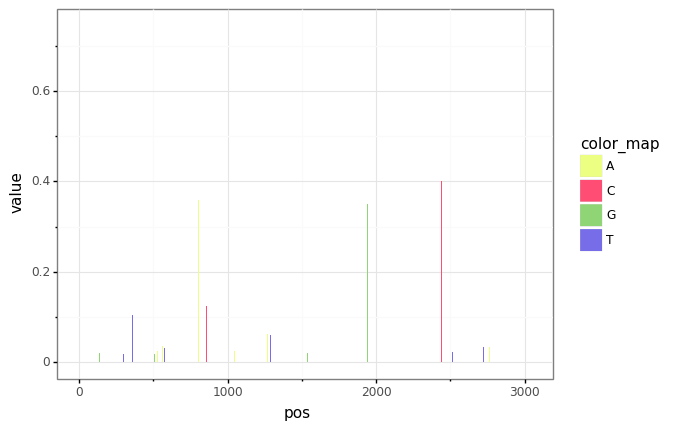

<ggplot: (-9223363305252941806)>


In [67]:

print("plotting")
plot=(ggplot(reshaped)        
 + aes(x='pos', y='value', fill="color_map")      
 +geom_bar(position="stack",stat="identity")
 +scale_fill_manual(values={"T":"#786de9", "A":"#ecff82","C":"#ff4d73", "G":"#90d575"})
 #+scale_x_categorical()
)
print(plot+theme_bw())
#color (in eas è il colore dell'outline), fill il colore dell'interno della barra

In [62]:
#saving
ggsave(plot+coord_cartesian(ylim=[0,0.6])+theme_bw(), filename="imgs/af_after_calling"+samplename+".png", width=60, height=2*6, limitsize=False)


/home/lorenzo/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 60 x 12 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/lorenzo/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: imgs/af_after_callingS1_dedup.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


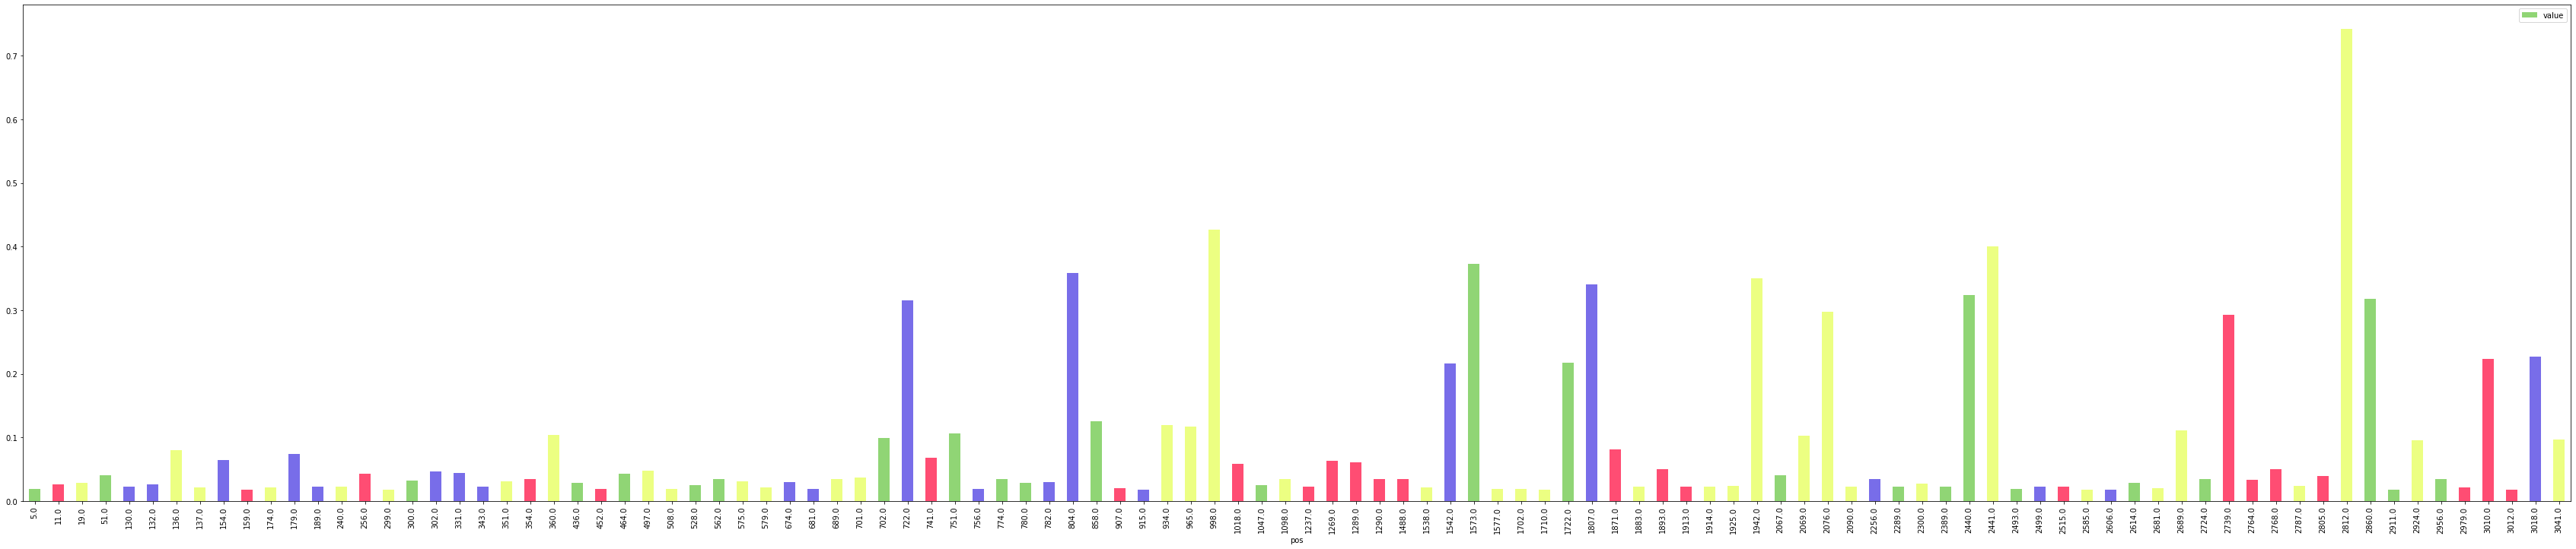

In [95]:
#use matplotlib x plottare solo le variantine

reshaped_formatplotlib=reshaped[reshaped["value"]!=0.000]
color_of={"T":"#786de9", "A":"#ecff82","C":"#ff4d73", "G":"#90d575"}


reshaped_formatplotlib.plot(kind="bar", x="pos", y="value", color=[color_of[ref] for ref in reshaped_formatplotlib["ref"]], figsize=(60,12))
plt.savefig("imgs/prv.png")